In [20]:
#import the necessary libraries
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [21]:
#read the data with pandas
data= pd.read_csv(os.path.join("..","data","customer_segmentation_100k.csv"))

In [22]:
#now we will create our features for our RFM scores which stands for Recency-Frequency-Monetary
# Set reference date as today
today = datetime.today()

# Convert last_order_date column to datetime type
data['last_order'] = pd.to_datetime(data['last_order'])

# Calculate days since last order for each row
data['days_passed_since_last_order'] = (today - data['last_order']).dt.days

data.head(1)

,customer_id,qtt_order,total_spent,last_order,days_passed_since_last_order
0,0,41,321785.93,2022-08-04 01:00:00,279


In [23]:
#for monetary we will use the total_spent column besides the average spent for order
data = data.assign(avg_spent_per_product=(data['total_spent'] / data['qtt_order']).fillna(0))

# Replace infinite values with a large finite value before converting to integer data type
data['avg_spent_per_product'].replace([np.inf, -np.inf], np.iinfo(np.int32).max, inplace=True)
data['avg_spent_per_product'] = data['avg_spent_per_product'].astype(int)
data.head(1)

,customer_id,qtt_order,total_spent,last_order,days_passed_since_last_order,avg_spent_per_product
0,0,41,321785.93,2022-08-04 01:00:00,279,7848


In [24]:
#for frequency, we have only the qqt_order column which represents the number of orders, thus our final data is:
data=data[["customer_id","qtt_order","total_spent","days_passed_since_last_order","avg_spent_per_product"]]

In [25]:
# Standardize the numerical variables
scaler = StandardScaler()
num_vars = ['qtt_order', 'total_spent', 'days_passed_since_last_order', 'avg_spent_per_product']
data[num_vars] = scaler.fit_transform(data[num_vars])

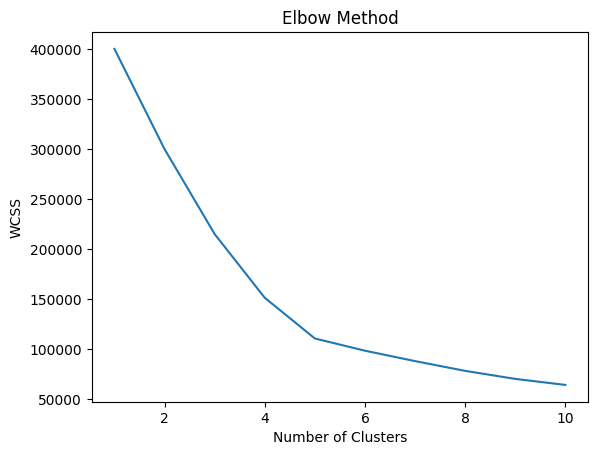

In [26]:
# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data[num_vars])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [27]:
# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(data[num_vars])

# Add cluster labels to the dataframe
data['cluster'] = y_kmeans

# Analyze the characteristics of each cluster
cluster_means = data.groupby('cluster').mean()
print(cluster_means)

          customer_id  qtt_order  total_spent  days_passed_since_last_order  \
cluster                                                                       
0        50030.797857   2.766654     0.432283                     -0.163691   
1        50118.937591  -0.295287    -0.343290                      0.852523   
2        49792.584932  -0.248569    -0.289640                     -0.907036   
3        48323.733333  -0.768418    -0.598838                      0.272374   
4        50247.326951   0.129437     2.220773                     -0.172775   

         avg_spent_per_product  
cluster                         
0                    -0.032504  
1                    -0.032427  
2                    -0.032432  
3                    30.844463  
4                    -0.032291  


In [28]:
# Invert the standardization process to get back the original data
data[num_vars] = scaler.inverse_transform(data[num_vars])
data.head(1)

,customer_id,qtt_order,total_spent,days_passed_since_last_order,avg_spent_per_product,cluster
0,0,41.0,321785.93,279.0,7848.0,2


In [ ]:
data['total_spent'] = data['total_spent'].round(0)  #rounding the column values
data['avg_spent_per_product'] = data['avg_spent_per_product'].round(0)

In [8]:
# Define the mapping of numbers to labels
label_mapping = {0: 'Loyal Spenders', 1: 'Occasional Engagers', 2: 'Rapid Repeaters',3: 'Potential Lost',4: 'High-Value Regulars'}

# Encode the numbers column with the labels
data['cluster'] = data['cluster'].replace(label_mapping)

In [11]:
data.to_csv(os.path.join("..", "data", "RFM_data.csv"),index=False)